In [1]:
import torch 
from torch.utils import data as d
from torch.nn import functional as F
from torch.autograd import Variable
from torch import optim, nn


from torchvision import models,transforms
import torchvision as tv

import numpy as np

from sklearn import model_selection as ms
from sklearn import preprocessing as pp
from sklearn import metrics

from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

from tqdm import tqdm
import line_profiler

train_loader = torch.utils.data.DataLoader(
    tv.datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=45, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    tv.datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=45, shuffle=True)

train_loader

model = models.vgg19(pretrained=True)

model.parameters

In [2]:
from torchvision.transforms import Compose, RandomCrop, ToTensor, Scale, RandomHorizontalFlip
from torch.utils.data import Dataset
import os 
from PIL import Image

import sys


# datasets_root='/home/zohar/datasets/'
# s291=datasets_root+'291'
# s91=datasets_root+'91'
# s14=datasets_root+'Set14'
# s5=datasets_root+'Set5'
# b200=datasets_root+'BSD200'
# b100=datasets_root+'BSD100'

def transform_target(crop_size):
    """Ground truth image    """
    return Compose([
        RandomCrop(crop_size),
        RandomHorizontalFlip(),
        ])


def transform_input(crop_size, upscale_factor):
    """LR of target image    """
    return Compose([
        Scale(crop_size
              // upscale_factor,Image.BICUBIC),
             ])


def fit_crop_size(crop_size, upscale_factor):
    return crop_size - crop_size % upscale_factor


def get_train_set(traindir,crop_size=256,upscale_factor=4):
    """
    crop_size : int, def=256
    upscale_factor : int, def=4
    train_dir : srt, path
    
    """
    crop_size = crop_size
    crop_size = fit_crop_size(crop_size, upscale_factor)
    return ImageDataset(
        traindir,
        crop_size,
        transform_target=transform_target(crop_size),
        transform_input=transform_input(crop_size, upscale_factor))


def get_val_set(args):
    crop_size = args.crop_size
    crop_size = fit_crop_size(crop_size, args.upscale_factor)
    return ImageDataset(
        args.valdir,
        transform_target=transform_target(crop_size),
        transform_input=transform_input(crop_size, args.upscale_factor))

class ImageDataset(Dataset):
    def __init__(self,path_file,crop_size, transform_target=None, transform_input=None):
        super(ImageDataset,self).__init__()
        #self.image_filenames = [os.path.join(path_file,x) for x in os.listdir(path_file)]
        with open(path_file) as f:
            self.image_filenames = f.read().splitlines()[:240000]#[:8000]#open(path_file).read().splitlines()#('\n')
        
        self.transform_target = transform_target
        self.transform_input = transform_input
        self.crop_size=crop_size

    def __getitem__(self, index):
        target = Image.open(self.image_filenames[index])
       # size=target.size
       # rate = self.crop_size*1.25/min(size)
       # target=target.resize((int(size[0]*rate),int(size[1]*rate)),Image.BICUBIC)
        if self.transform_target:
            target = self.transform_target(target)
        input = target.copy()
        if self.transform_input:
            input = self.transform_input(input)
        target = ToTensor()(target)
        input = ToTensor()(input)
        return input,target

    def __len__(self):
        return len(self.image_filenames)
    
fp = "img160_list.txt"#"
#fp = "tw_img_list.txt"
bs=32
workers=6
cs = 160#160#400
upf = 4

train_data = torch.utils.data.DataLoader(
    get_train_set(traindir=fp,crop_size=cs,upscale_factor=upf),
    batch_size=bs, shuffle=True,
    num_workers=workers, pin_memory=True)

/home/kawa/anaconda3/lib/python3.6/site-packages/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [3]:
len(train_data) #*32

7500

In [4]:
def normalize(tensor):
    r,g,b=torch.split(tensor,1,1)
    r=(r-0.485)/0.229
    g=(g-0.456)/0.224
    b=(b-0.406)/0.225
    return torch.cat((r,g,b),1)

In [5]:
class Skip(nn.Module):
    def __init__(self):
        super(Skip,self).__init__()

    def forward(self, input):
        return input

def vgg19_54():
    model = models.vgg19(pretrained=True)
    # remove last max pooling
    model.features = nn.Sequential(*list(model.features.children())[:-1])
    model.classifier = Skip()
    return model

In [6]:
vgg = vgg19_54().cuda()

In [7]:
class SR_Generator_ResBlock(nn.Module):
    def __init__(self):
        super(SR_Generator_ResBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(64)
        self.p_relu = nn.PReLU()

        
    def forward(self, x):
        h = self.p_relu(self.bn1(self.conv1(x)))
        h = self.bn2(self.conv2(h))
        return h + x
    
class SR_Generator_Upscale(nn.Module):
    def __init__(self,ups:int):
        super(SR_Generator_Upscale, self).__init__()
        self.pixel_shuffle = nn.PixelShuffle(ups)
        self.conv1 = nn.Conv2d(64, 256, 3, 1, 1)#64 x 256
        self.p_relu = nn.PReLU()

    def forward(self, x):
        h = self.conv1(x)
        h = self.pixel_shuffle(h)
        h = self.p_relu(h)
        return h

In [8]:
class SR_generator(nn.Module):
    def __init__(self,ups):
        super(SR_generator, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, 9, 1, (9-1)//2)
#         self.res1 = SR_Generator_ResBlock()
#         self.res2 = SR_Generator_ResBlock()
#         self.res3 = SR_Generator_ResBlock()
#         self.res4 = SR_Generator_ResBlock()
#         self.res5 = SR_Generator_ResBlock()
        self.conv2 = nn.Conv2d(64, 64, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.upscale1 = SR_Generator_Upscale(ups)
        self.upscale2 = SR_Generator_Upscale(ups)
        
        layers = []
        for i in range(8):
            layers.append(SR_Generator_ResBlock())
        self.res_layer = nn.Sequential(*layers)
        
        self.conv3 = nn.Conv2d(64, 3, 9, 1, (9-1)//2)
        
        self.tanh = nn.Hardtanh()
        self.p_relu = nn.PReLU()

    def forward(self, x):
        #x = x*2 - 1.0
        h = f = self.p_relu(self.conv1(x))
        #print(x.size(),h.size())
#         h = self.res1(h)
#         h = self.res2(h)
#         h = self.res3(h)
#         h = self.res4(h)
#         h = self.res5(h)
        h = self.res_layer(h)
        #print(h.size())
        
        h = self.bn1(self.conv2(h))
        #print(m.size())
        h = f + h
        
        h = self.upscale2(self.upscale1(h))
        #h = self.upscale1(h)
        
        h = self.conv3(h)
        #h = self.tanh(h)
        #h = (h+1)/2.0
        #return self.tanh(h)
        h = F.sigmoid(h)
        #h = F.tanh(h)
        return h

In [9]:
class SR_Discriminator(nn.Module):
    def __init__(self,bs):
        super(SR_Discriminator, self).__init__()
        
        self.bs = bs
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(64, 64, 3, 2, 0)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 0)
        self.conv4 = nn.Conv2d(128, 128, 3, 2, 0)
        self.conv5 = nn.Conv2d(128, 256, 3, 1, 0)
        self.conv6 = nn.Conv2d(256, 256, 3, 2, 0)
        self.conv7 = nn.Conv2d(256, 512, 3, 1, 0)
        self.conv8 = nn.Conv2d(512, 512, 3, 2, 0)
        
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(256)
        self.bn6 = nn.BatchNorm2d(512)
        self.bn7 = nn.BatchNorm2d(512)
        
        self.l1 = nn.Linear(in_features=512*7*7, out_features=1024)
        self.l2 = nn.Linear(in_features=1024, out_features=2)
        
        self.pool = nn.AdaptiveAvgPool2d(1)
        #self.Dense1 = nn.Conv2d(in_channels=512,out_channels=1024,kernel_size=1)
        #self.Dense2 = nn.Conv2d(in_channels=1024,out_channels=2,kernel_size=1)
        
        
    def forward(self, x):
        h = F.leaky_relu(self.conv1(x))
        h = self.bn1(F.leaky_relu(self.conv2(h)))
        h = self.bn2(F.leaky_relu(self.conv3(h)))
        h = self.bn3(F.leaky_relu(self.conv4(h)))
        h = self.bn4(F.leaky_relu(self.conv5(h)))
        h = self.bn5(F.leaky_relu(self.conv6(h)))
        h = self.bn6(F.leaky_relu(self.conv7(h)))
        h = self.bn7(F.leaky_relu(self.conv8(h)))
        self.o = h
        bs, ns,nx,ny = h.size()
        h = h.view(self.bs,512*nx*ny)#ns*nx*ny)
        
        h = F.leaky_relu(self.l1(h))
        #h = F.sigmoid(self.l2(h))
        h = F.softmax(self.l2(h),1) 
        #h=F.leaky_relu(self.Dense1(self.pool(h)))
        #h=self.Dense2(h).view(self.bs,-1)
        
        #h = F.sigmoid(h)
        
        return h

In [10]:
gen_m = SR_generator(2).cuda()

In [11]:
disc_m = SR_Discriminator(bs).cuda()

In [12]:
# disc_state = torch.load("discriminator40_10.pth")
# gen_state = torch.load("generator40_10.pth")

In [13]:
# disc_m.load_state_dict(disc_state)
# gen_m.load_state_dict(gen_state)

In [14]:
gen_opt = optim.SGD(gen_m.parameters(), lr=0.05)
disc_opt = optim.SGD(disc_m.parameters(), lr=0.02)

In [15]:
mse_cri = nn.MSELoss().cuda()
#bce_cri = nn.BCELoss().cuda()
cel_cri = nn.CrossEntropyLoss().cuda()

In [16]:
label=Variable(torch.FloatTensor(bs)).cuda()
label1=Variable(torch.LongTensor(bs)).cuda()
clip = True#False

In [26]:
len(train_data)

7500

In [27]:
len(train_data)/1000

7.5

## Test

In [17]:
gen_count=80
cs1 = 40
cs2 = 160
trans = Compose([RandomCrop(cs1),RandomHorizontalFlip()])
trans1 = Compose([RandomCrop(cs2),RandomHorizontalFlip()])
test_imgs = [Image.open("test{}.jpg".format(i+1)) for i in range(16)]

v_tests = torch.ones((16,3,cs1,cs1))
for k,ti in enumerate(test_imgs):
    moz_img = ti.resize((cs1,cs1)).convert("RGB")
    test_arr = ToTensor()(trans(moz_img))
    v_tests[k] = test_arr.unsqueeze(0)
v_test_img = Variable(v_tests).cuda()

v_tests_target = torch.ones((16,3,cs2,cs2))
for k,ti in enumerate(test_imgs):
    moz_img = ti.resize((cs2,cs2)).convert("RGB")
    test_arr = ToTensor()(trans1(moz_img))
    v_tests_target[k] = test_arr.unsqueeze(0)
v_test_target_img = Variable(v_tests_target).cuda()


#os.mkdir("gen_image/gen".format(gen_count))
# for te_c, v_test in enumerate(v_test_img):
#     gen_test = gen_m(v_test.unsqueeze(0))
#     res = gen_test.cpu().data
#     rgb = transforms.ToPILImage()(torch.squeeze(res))
#     rgb.save("gen_image/gen/gen_test{0}_{1}.jpg".format(gen_count,te_c))
# gen_count+=1

In [18]:
fake_gen_imgs = vgg(normalize(gen_m(v_test_img)))

real_gen_imgs = vgg(normalize(v_test_target_img)).detach()

print(mse_cri(fake_gen_imgs,real_gen_imgs))

Variable containing:
 0.6571
[torch.cuda.FloatTensor of size 1 (GPU 0)]



%load_ext line_profiler

%lprun -f func1 func1()

## train

In [ ]:
#def func1():
w = 0.001#0.001
epoch1 = range(1,4)
epoch2 = range(2)
gen_count=0
#sep = False#True
div = 1
loss_list = []
vali_loss = []
for it in range(1000):
    for e in epoch1:
        count = 0
        l = []
        #print("train",e)
        bar = tqdm(range(len(train_data)))
        for i,dt in enumerate(train_data):#(train_loader):
            count=i+1
            in_data,in_target = dt
            #if i > 1000:
            if dt[1].size()[0] != bs:
                #continue
                break
            in_data, in_target = Variable(in_data).cuda(),Variable(in_target).cuda()

            gen_opt.zero_grad()
            gen_img = gen_m(in_data)
            fake = vgg(normalize(gen_img))
            real = vgg(normalize(in_target))
            #fake = vgg(gen_img)
            #real = vgg(in_target)

            #gp_loss = torch.sum((in_target-gen_img)**2)/500

            mse_loss = mse_cri(fake,real.detach())
            label1.data.fill_(1) 
            out = disc_m(gen_img)
            cel_loss = cel_cri(out,label1)/1000#bce_cri(out, label.unsqueeze(1))
            #gen_loss = w * 
            #gen_loss = cel_loss + mse_loss# + (0.001 * gp_loss) 
            gen_loss = cel_loss + mse_loss# + gp_loss 
            gen_loss.backward()
            if clip:
                torch.nn.utils.clip_grad_norm(gen_m.parameters(),clip)

            gen_opt.step()
            
            bar.update(1)
        bar.close()
        bar.clear()
#             if count % 10 == 0:
#                 #print(it,it2,e,end=" : ")
#                 #print(count,end=" : ")
#                 #print("gen",gen_loss.data.mean())
#                 l.append(gen_loss.data.mean())  
        if e %1 == 0:
            print(it,e,end=" : ")
            l.append(gen_loss.data.mean())
            print("gen",gen_loss.data.mean())#np.mean(l))#gen_loss.data.mean())
        loss_list.append(np.mean(l))
    for e in epoch2:

        count = 0
        l = []
        #print("train",e)
        
        
        bar = tqdm(range(len(train_data)))
        for i,dt in enumerate(train_data):#(train_loader):
            count=i+1
            in_data,in_target = dt
            #if i > 2000:
            if dt[1].size()[0] != bs:
                #continue
                break
            in_data, in_target = Variable(in_data).cuda(),Variable(in_target).cuda()

            disc_opt.zero_grad()
            label1.data.fill_(1)
            out=disc_m(in_target)
            real_loss=cel_cri(out,label1)#mse_cri(out,label)#.unsqueeze(1))
            real_loss.backward()
            disc_opt.step()

            disc_opt.zero_grad()
            label1.data.fill_(0)
            out=disc_m(gen_m(in_data))#.detach())
            fake_loss=cel_cri(out,label1)#mse_cri(out,label)#.unsqueeze(1))
            fake_loss.backward()
            disc_opt.step()

            disc_loss = (real_loss + fake_loss)/2
            
            bar.update(1)
        bar.close()
        bar.clear()
            #disc_loss.backward()
            #disc_opt.step()

            #if count % 100 ==0:
                #print(it,e,end=" : ")
                #print(count)
                #print("disc",disc_loss.data.mean())
                #l.append(disc_loss.data.mean())
        if e %1 == 0:
            print(it,e,end=" : ")

            print("disc",disc_loss.data.mean())
        #print("disc",np.mean(l))
        
    fake_gen_imgs = vgg(normalize(gen_m(v_test_img)))
    real_gen_imgs = vgg(normalize(v_test_target_img)).detach()
    test_loss = mse_cri(fake_gen_imgs,real_gen_imgs)
    print(test_loss.data.mean())
    vali_loss.append(test_loss.data.mean())
#     print()
#     if gen_count % 2 == 0:
#         os.mkdir("gen_image/gen80_{0}".format(gen_count))
#         for te_c, v_test in enumerate(v_test_img):
#             gen_test = gen_m(v_test.unsqueeze(0))
#             res = gen_test.cpu().data
#             rgb = transforms.ToPILImage()(torch.squeeze(res))
#             rgb.save("gen_image/gen80_{0}/gen_test{0}_{1}.jpg".format(gen_count,te_c))
#     gen_count+=1

In [122]:
bar.close()
bar.clear()

In [58]:
in_target.size()

torch.Size([32, 3, 160, 160])

In [59]:
in_data.size()

torch.Size([32, 3, 40, 40])

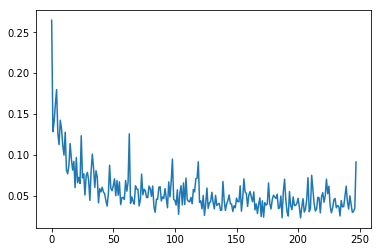

In [20]:
plt.plot(loss_list)

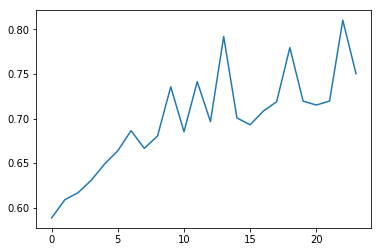

In [21]:
plt.plot(vali_loss)

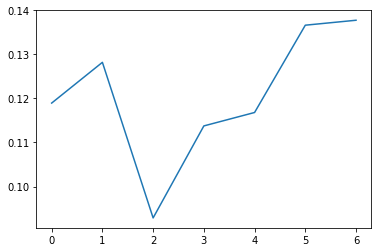

In [109]:
plt.plot(loss_list)

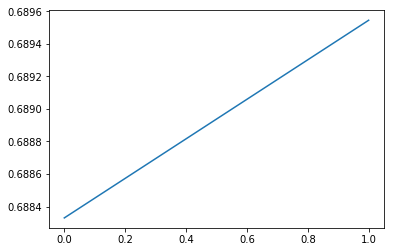

In [108]:
plt.plot(vali_loss)

In [24]:
    fake_gen_imgs = vgg(normalize(gen_m(v_test_img)))
    real_gen_imgs = vgg(normalize(v_test_target_img)).detach()
    test_loss = mse_cri(fake_gen_imgs,real_gen_imgs)
    print(test_loss.data.mean())
    vali_loss.append(test_loss.data.mean())

0.5748127102851868


In [111]:
cel_loss,mse_loss,gen_loss,disc_loss

(Variable containing:
  313.2617
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  0.1218
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  313.3835
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  0.3133
 [torch.cuda.FloatTensor of size 1 (GPU 0)])

In [20]:
torch.save(gen_m.state_dict(), 'generator40_11.pth')
torch.save(disc_m.state_dict(), 'discriminator40_11.pth')

## check

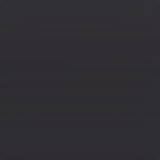

In [39]:
im_arr = gen_img[9].cpu().data

rgb = transforms.ToPILImage()(torch.squeeze(im_arr))

Image.fromarray(np.array(rgb).transpose(0,1,2))

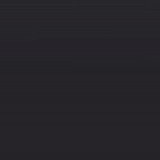

In [38]:
img = transforms.ToPILImage()(torch.squeeze(in_target[9].cpu().data))
img

## test

In [108]:
test_img = Image.open("test7.jpg")

In [109]:
moz_img = test_img.resize((40,40)).convert("RGB")#.resize((100,100))

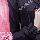

In [110]:
moz_img

In [111]:
test_arr = np.array(moz_img).transpose(2,0,1).reshape(1,3,40,40)

In [112]:
cs1 = 40
cs2 = 160
trans = Compose([RandomCrop(cs1),RandomHorizontalFlip()])
trans1 = Compose([RandomCrop(cs2),RandomHorizontalFlip()])

In [113]:
test_arr = ToTensor()(trans(moz_img))

In [114]:
test_arr.size()

torch.Size([3, 40, 40])

In [115]:
test_arr.unsqueeze(0).size()

torch.Size([1, 3, 40, 40])

In [116]:
v_test = Variable(test_arr).cuda()

In [117]:
gen_test = gen_m(v_test.unsqueeze(0))

In [118]:
res = gen_test.cpu().data

In [119]:
rgb = transforms.ToPILImage()(torch.squeeze(res))

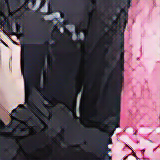

In [120]:
rgb

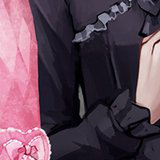

In [121]:
test_img.resize((160,160))

In [220]:
target_img = test_img.resize((160,160)).convert("RGB")#.resize((100,100))
test_target = ToTensor()(trans1(target_img))
v_test_target = Variable(test_target).cuda()

In [217]:
test_v = vgg(gen_test)

In [224]:
test_target_v = vgg(v_test_target.unsqueeze(0))

In [226]:
test_loss = mse_cri(test_v,test_target_v.detach())

In [227]:
test_loss

Variable containing:
 0.3363
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [17]:
w = 0.001
epoch = range(3)
sep = False
for e in epoch:
    print("train",e)
    for i,dt in enumerate(train_data):#(train_loader):
        in_data,in_target = dt
        in_data, in_target = Variable(in_data).cuda(),Variable(in_target).cuda()
        
#         gen_m.zero_grad()
#         gen_img = gen_m(in_data)
        
#         fake_res = vgg(gen_img)
#         real_res = vgg(in_data)
        
#         mse_loss = mse_cri(fake_res, real_res)
# #         mse_loss = mse_cri(gen_img, in_data)
#         mse_loss.backward()
#         gen_opt.step()
        
        if sep:
            disc_opt.zero_grad()
            real_loss=((disc_m(in_target)-1)**2).mean()#
            
            real_loss.backward()
            #torch.nn.utils.clip_grad_norm(disc.parameters(),args.clip)
            disc_opt.step()

            fake_loss=torch.mean(disc_m(gen_m(in_data))**2)#
            disc_opt.zero_grad()
            fake_loss.backward()
            #torch.nn.utils.clip_grad_norm(disc.parameters(),args.clip)
            disc_opt.step()
            disc_loss=(fake_loss+real_loss)/2

        else:
            disc_opt.zero_grad()
            label.data.fill_(1)
            out=disc_m(in_target)
            real_loss=bce_cri(out,label.unsqueeze(0))
            label.data.fill_(0)
            out=disc_m(gen_m(in_data).detach())
            fake_loss=bce_cri(out,label.unsqueeze(0))
            disc_loss=w*(fake_loss+real_loss)*100
            disc_loss.backward()
            disc_opt.step()
            
        if i%100 ==0:
            print(i)
            print("disc",disc_loss.data.mean())
        

#for e in epoch:
        #print("train2",e)
#    for i,dt in enumerate(train_data):
        #in_data,in_target = dt
        #in_data, in_target = Variable(in_data).cuda(), Variable(in_target).cuda()
        
        gen_opt.zero_grad()
        gen_img = gen_m(in_data)
        fake = vgg(gen_img)
        real = vgg(in_target)
        
        mse_loss = mse_cri(fake,real.detach())#gen_img, in_data)
        #mse_loss.backward()
        #gen_opt.step()

        label.data.fill_(1) 
        out = disc_m(gen_img)
        bce_loss = bce_cri(out, label.unsqueeze(1))
        gen_loss = w * bce_loss + mse_loss
        gen_loss.backward()
        if clip:
            torch.nn.utils.clip_grad_norm(gen_m.parameters(),clip)
        gen_opt.step()
        if i % 100 == 0:
            print("gen",gen_loss.data.mean())
    

train 0
0


/home/kawa/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1168: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([2, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


disc 2.7631022930145264
gen 3.4369332790374756
100
disc 2.7631022930145264
gen 2.248857259750366
200
disc 2.7631022930145264
gen 2.0049755573272705
300
disc 2.7631022930145264
gen 1.7982618808746338
400
disc 2.7631022930145264
gen 2.1584460735321045
500
disc 2.7631022930145264
gen 1.2099727392196655
600
disc 2.7631022930145264
gen 1.1249586343765259
700
disc 2.7631022930145264
gen 0.9208279252052307
800
disc 2.7631022930145264
gen 1.019954800605774
900
disc 2.7631022930145264
gen 1.4959405660629272
train 1
0
disc 2.7631022930145264
gen 0.6831234097480774
100
disc 4.144653797149658
gen 0.5525022745132446
200
disc 2.7631022930145264
gen 0.6037073135375977
300
disc 4.144653797149658
gen 1.5582644939422607
400
disc 2.7631022930145264
gen 0.4807072877883911
500
disc 4.144653797149658
gen 0.520926296710968
600
disc 2.7631022930145264
gen 0.6917307376861572
700
disc 2.7631022930145264
gen 0.41667047142982483
800
disc 1.3815511465072632
gen 0.3674663007259369
900
disc 2.7631022930145264
gen 0.

In [64]:
im = np.uint8(gen_img.cpu().data.numpy()[0,:,:,:].transpose(1,2,0))

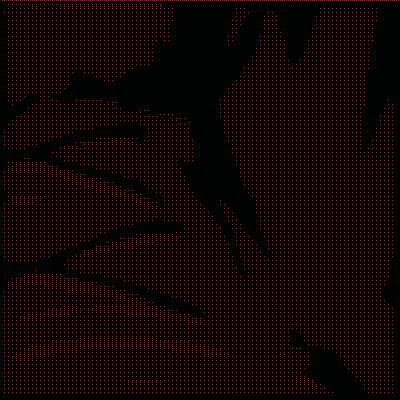

In [65]:
Image.fromarray(im)

In [66]:
testimg = Image.open("test3.jpg")

In [67]:
test_img = testimg.resize((100,100))

In [68]:
test_narr = np.array(test_img)

In [69]:
alt_test = test_narr.transpose(2,0,1)

In [70]:
test_im = np.array([alt_test for i in range(2)])

In [71]:
t_test_im = torch.FloatTensor(test_im.astype(float))

In [72]:
v_test_im = Variable(t_test_im).cuda()

In [73]:
res = gen_m(v_test_im)

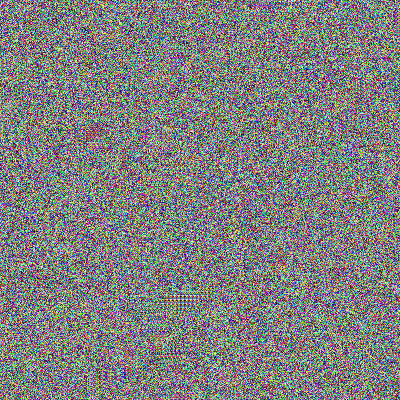

In [75]:
Image.fromarray(np.uint8(res[0].cpu().data.numpy().transpose(1,2,0)))